In [1]:
## importing libraries

## dataframe & numerical minipulation 
import pandas as pd
import numpy as np
from math import sqrt
import datetime

## for webscraping & text cleaning
from bs4 import BeautifulSoup
import requests
import re

## for plotting & EDA
import seaborn as sns
import matplotlib.pyplot as plt

## for modelling
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Functions

In [2]:
def word_finder_team(text):
    '''
    Takes in text and returns all text ater ">
    '''
    a = re.search(r'">.*',text).group()
    return a
    
def clean_number(text):
    '''
    Takes in text and returns the digit characters.
    If there are no digit characters, returns N/A
    '''
    try:
        a = re.search(r'[0-9.,]+',text).group()
    except AttributeError: 
        a = 'N/A'
    return a

In [3]:
def race_data(year,race):
    '''
    takes int int string, string, returns a list
    inputs:
    start year: from 1935 vuelta, 1903 tour, 1909 giro 
    end year: latest 2021
    race: vuelta-a-espana, tour-de-france, or giro-d-italia suggested
    output: lists of the rank, age, team, and time after finish between these years
    '''
    
    assert int(year) > 1935 and int(year) < datetime.datetime.now().year
    , 'Earliest year must be 1935, latest year must be current year'
    assert race in ('tour-de-france', 'vuelta-a-espana','giro-d-italia'), "races are 'tour-de-france','vuelta-a-espana','giro-d-italia'"
    
    link = 'https://www.procyclingstats.com/race/'+race+'/'+str(year)+'/gc/'
    result = requests.get(link)
    soup = BeautifulSoup(result.text, 'html.parser')

    ## Ranks
    rank = [x.td for x in soup.findAll('tr')]
    rank_nonone = list(filter(None, rank))
    ranks = []
    for n in rank_nonone:
        a = clean_number(str(n))
        ranks.append(a)
    index_from = [i for i, n in enumerate(ranks) if n == '1'][1]
    if [i for i, n in enumerate(ranks) if n == '1'][2] - index_from < 20:
        index_to = [i for i, n in enumerate(ranks) if n == '1'][3]
    else:
        index_to = [i for i, n in enumerate(ranks) if n == '1'][2]
    ranks = ranks[index_from : index_to]

    ## Names
    names = [x.a for x in soup.findAll('tr')]
    names_nonone = list(filter(None, names))
    rider = []
    for n in names_nonone:
        if ("rider" in str(n)) == True:
            a = word_finder_team(str(n))
            a = a.replace('">','')
            a = a.replace('</a>','')
            rider.append(a)
    rider = rider[index_from : index_to]

    ## Times
    time = [x.text for x in soup.findAll('td', class_='time ar')]
    time = time[index_from : index_to] 
    new_times = []
    for t in time: 
        a = t.replace(',,','error')
        a = t.replace(',','')
        a = a.replace(' ','')
        if len(a) > 8:
            middle = int(len(a)/2)
            a = a[:middle]
            new_times.append(a)
        else:
            new_times.append(a)

    finish_time = new_times.pop(0)
    new_times.insert(0,'0')
    time = []
    for t in new_times: 
        if len(t) > 7:
            middle = int(len(t)/2)
            t = t[:middle]
            time.append(t)
        else:
            time.append(t)

    ## Teams
    team = [x.text for x in soup.findAll('td', class_='cu600')]
    team = team[index_from : index_to]

    ## Ages
    age = [x.text for x in soup.findAll('td', class_="age hide")]
    age = age[index_from : index_to]
    
    ## Year column
    years = [year for x in range(len(ranks))]
    
    return years, ranks, rider, age, team, time

In [4]:
def race_data_multiple_years(start,end,race):
    '''
    Applies the race_data fuction over multiple years, returns a dataframe of all valid years,
    plus prints any years that errored such that this can be manually searched
    '''
    year = [] 
    rank = [] 
    rider = []
    age = []
    team = []
    time = []
    for n in range(start,end):
        y, ra, ri, a, te, ti = race_data(n,race)
        if len(y)==len(ra)==len(ri)==len(a)==len(te)==len(ti):
            year += y
            rank += ra
            rider += ri
            age += a
            team += te
            time += ti
        else:
            print(n)
    coldict = {'year': year, 'rank': rank, 'rider': rider, 'age':age, 'team':team, 'time':time} 
    tdf_rank = pd.DataFrame(coldict)
    return tdf_rank

In [5]:
def standardise_name(name):
    '''
    For a text name, splits at a whitespace, reverses the order, and uppercases the new first word
    e.g. Mark Cavendish -> CAVENDISH Mark
    '''
    if ' ' in name:
        oldname = name.split(' ')
        surname = oldname[1].upper()
        firstname = oldname[0]
        fullname = surname + ' ' + firstname
    else:
        fullname = name
    return fullname

In [6]:
def format_list(list):
    '''
    Applies the standardise_name function to a list of names, returns a list of the modified names
    '''
    lst = []
    for y in list: 
        z = standardise_name(y)
        lst.append(z)
    return lst

In [7]:
def clean_time(text):
    '''
    Takes a time in form hh:mm:ss or mm:ss
    returns seconds as an integer
    '''
    if ':' in text:
        times = text.split(':')
        if len(times) == 3:
            try:
                total_time = (int(times[0])*60*60) + (int(times[1])*60) + (int(times[2]))
            except ValueError:
                total_time = 'error '+text
        elif len(times) == 2:
            try:
                total_time = (int(times[0])*60) + (int(times[1]))
            except ValueError:
                total_time = 'error '+text
        else:
            total_time = 'error '+text
    else:
        total_time = int(text)
    return total_time

In [8]:
def word_finder_team(text):
        a = re.search(r'">.*',text).group()
        return a
    
def top3teamsprev(year_start,year_end,race):
    '''
    takes int int string, returns list of lists
    inputs:
    enter start year: from 1935 vuelta, 1903 tour, 1909 giro 
    end year: latest 2021
    race: vuelta-a-espana, tour-de-france, or giro-d-italia suggested
    output: list of top 3 teams for a race between years provided
    '''
    teams = []
    years = [x for x in range(year_start,year_end+1)]
    for n in range(year_start,year_end+1):
        link = 'https://www.procyclingstats.com/race/'+race+'/'+str(n)
        result = requests.get(link)
        soup = BeautifulSoup(result.text, 'html.parser')
        souplist = [x.a for x in soup.findAll('tr')]
        res = list(filter(None, souplist))
        teamlist = []
        for h in res:
            if ("team" in str(h)) == True:
                teamlist.append(h)
        teamlist = teamlist[0:3]
        team = []
        for h in teamlist:
            a = word_finder_team(str(h))
            a = a.replace('">','')
            a = a.replace('</a>','')
            team.append(a)
        teams.append(team)
    teams.insert(0,'N/A')
    teams.pop()
    coldict = {'year': years, 'top_3_teams_prev_year': teams} 
    top_3_teams = pd.DataFrame(coldict)
    return top_3_teams

In [9]:
def count_past_wins(start_year, end_year, classlist, df, race):
    '''
    Counts number of wins, given a race, per rider 
    '''
    if race == 'giro':
        span = [x for x in range(1909,2022)]
    elif race == 'tour':
        span = [x for x in range(1903,2022)]
    elif race == 'vuelta':
        span = [x for x in range(1935,2022)]
    prev = []
    for n in range(len(df)):
        year = df.loc[n,'year']
        rider = df.loc[n,'rider']
        year_index = span.index(year)
        name = classlist[:year_index]
        #print(name)
        past = name.count(rider)
        prev.append(past)
    return prev

In [10]:
vuelta_years = [x for x in range(1935,2022)]
tour_years = [x for x in range(1903,2022)]
giro_years = [x for x in range(1909,2022)]

# Data Importing and Scraping

## Scraping data for each race in time range specified

In [11]:
## Running the race data function to create a dataframe of Tour data 1960-2018
tdf_rank = race_data_multiple_years(1960,2018,'tour-de-france')

In [12]:
## Running the race data function to create a dataframe of Giro data 1960-2018
giro_rank = race_data_multiple_years(1960,2018,'giro-d-italia')

tdf_rank = pd.merge(tdf_rank, giro_rank.add_suffix('_giro'),  how='left', left_on=['year','rider'], right_on=['year_giro','rider_giro']).drop(columns= ['year_giro','rider_giro','age_giro'])


In [13]:
giro_winners = list(giro_rank[giro_rank['rank']=='1'].iloc[:,2])

In [14]:
giro_years = list(giro_rank[giro_rank['rank']=='1'].iloc[:,0])

In [15]:
tdf_rank['rank_giro'] = tdf_rank['rank_giro'].fillna(200)
tdf_rank['team_giro'] = tdf_rank['team_giro'].fillna('Unknown')

In [16]:
## Checking the data is in the correct format
tdf_rank.head()

,year,rank,rider,age,team,time,rank_giro,team_giro,time_giro
0,1960,1,NENCINI Gastone,30,Italy,0,2,Italy,0:28
1,1960,2,BATTISTINI Graziano,24,Italy,5:02,20,Italy,41:13
2,1960,3,ADRIAENSENS Jan,28,Belgium,10:24,12,Belgium,19:32
3,1960,4,JUNKERMANN Hans,26,West-Germany,11:21,14,West-Germany,30:01
4,1960,5,PLANCKAERT Joseph,26,Belgium,13:02,200,Unknown,NaN


In [17]:
## Running the race data function to create a dataframe of Vuelta data 1960-2018
vuelta_rank = race_data_multiple_years(1960,2018,'vuelta-a-espana')

1978


In [18]:
## Filling in the data for 1978, the year errored for the Vuelta

link = 'https://www.procyclingstats.com/race/vuelta-a-espana/1978/gc/'
result = requests.get(link)
soup = BeautifulSoup(result.text, 'html.parser')

## Ranks
rank = [x.td for x in soup.findAll('tr')]
rank_nonone = list(filter(None, rank))
ranks = []
for n in rank_nonone:
    a = clean_number(str(n))
    ranks.append(a)
index_from = [i for i, n in enumerate(ranks) if n == '1'][0]
if [i for i, n in enumerate(ranks) if n == '1'][1] - index_from < 20:
    index_to = [i for i, n in enumerate(ranks) if n == '1'][1]
else:
    index_to = [i for i, n in enumerate(ranks) if n == '1'][1]
ranks = ranks[index_from : index_to]

## Names
names = [x.a for x in soup.findAll('tr')]
names_nonone = list(filter(None, names))
rider = []
for n in names_nonone:
    if ("rider" in str(n)) == True:
        a = word_finder_team(str(n))
        a = a.replace('">','')
        a = a.replace('</a>','')
        rider.append(a)
rider = rider[index_from : index_to]

## Times
time = [x.text for x in soup.findAll('td', class_='time ar')]
time = time[index_from : index_to] 
new_times = []
for t in time: 
    a = t.replace(',,','error')
    a = t.replace(',','')
    a = a.replace(' ','')
    if len(a) > 8:
        middle = int(len(a)/2)
        a = a[:middle]
        new_times.append(a)
    else:
        new_times.append(a)

finish_time = new_times.pop(0)
new_times.insert(0,'0')
time = []
for t in new_times: 
    if len(t) > 7:
        middle = int(len(t)/2)
        t = t[:middle]
        time.append(t)
    else:
        time.append(t)

## Teams
team = [x.text for x in soup.findAll('td', class_='cu600')]
team = team[index_from : index_to]

## Ages
age = [x.text for x in soup.findAll('td', class_="age hide")]
age = age[index_from : index_to]

## Year column
years = [1978 for x in range(len(ranks))]

coldict = {'year': years, 'rank': ranks, 'rider': rider, 'age':age, 'team':team, 'time':time} 
vuelta1978 = pd.DataFrame(coldict)

print(len(years),len(ranks),len(rider),len(age),len(team),len(time))

64 64 64 64 64 64


In [19]:
## Joining this data to the Vuelta dataframe if it is meant to include year 1978
if vuelta_rank['year'].min() <= 1978:
    vuelta_rank = pd.concat([vuelta_rank, vuelta1978])

In [20]:
## Mering Vuelta and Tour data
tdf_rank = pd.merge(tdf_rank, vuelta_rank.add_suffix('_vuelta'),  how='left', left_on=['year','rider'], right_on=['year_vuelta','rider_vuelta']).drop(columns= ['year_vuelta','rider_vuelta','age_vuelta'])

In [21]:
tdf_rank['rank_vuelta'] = tdf_rank['rank_vuelta'].fillna(200)
tdf_rank['team_vuelta'] = tdf_rank['team_vuelta'].fillna('Unknown')

In [22]:
vuelta_winners = list(vuelta_rank[vuelta_rank['rank']=='1'].iloc[:,2])

In [23]:
vuelta_years = list(vuelta_rank[vuelta_rank['rank']=='1'].iloc[:,0])

## Scraping top 3 teams of the previous year

In [24]:
## Using top 3 teams function to scrape top 3 teams per year to a dataframe
top_3_teams = top3teamsprev(1960,2018,'tour-de-france')

In [25]:
## Merging this data with scraped Tour data on year
tdf_ranks = tdf_rank.merge(top_3_teams, how='left', on=['year'])

## Tour de France Stage Data (found dataset)

In [26]:
## Importing found dataset
stages = pd.read_csv('stages_TDF.csv')

In [27]:
## Formatting the name to match other data
stages['Winner'] = stages['Winner'].apply(standardise_name)

In [28]:
## Creating a year column from the date and making it an integer
stages['year'] = [x[:4] for x in stages['Date']]
stages['year'] = stages['year'].astype(int)

In [29]:
## Rename columns ready to merge with main dataframe
stages.rename(columns={'Winner':'rider','Distance':'distance','Type':'type'}, inplace=True)

In [30]:
## Creating a dataframe of average win distance per rider by grouping by rider and averaging the win times
average_win_distance = stages.groupby(['rider'],as_index = False)['distance'].mean()

In [31]:
## Merging average win distance with main dataframe on rider name to add this as a column
tdf_ranks = tdf_ranks.merge(average_win_distance, how='left', on = 'rider')
## For riders who have not won a stage, filling 0
tdf_ranks['distance'] = tdf_ranks['distance'].fillna(0)

In [32]:
## Creating dataframes of mountain stages and time trial stage types
mountain_stages = stages[stages['type'].str.contains('ountain')]
time_trial = stages.loc[(stages['type'].isin(['Individual time trial','Mountain time trial']))]

In [33]:
## Checking overall results for a well-known cyclist for accuracy
tdf_ranks[tdf_ranks['rider']=='FROOME Chris']

,year,rank,rider,age,team,time,rank_giro,team_giro,time_giro,rank_vuelta,team_vuelta,time_vuelta,top_3_teams_prev_year,distance
5507,2008,82,FROOME Chris,23,Barloworld,2:22:33,200,Unknown,NaN,200,Unknown,NaN,"[Discovery Channel , Caisse d'Epargne, CSC Pro...",148.071429
6063,2012,2,FROOME Chris,27,Sky Procycling,3:21,200,Unknown,NaN,4,Sky Procycling,10:16,"[Team Garmin - Cervélo, Leopard Trek, AG2R La ...",148.071429
6215,2013,1,FROOME Chris,28,Sky Procycling,0,200,Unknown,NaN,200,Unknown,NaN,"[RadioShack - Nissan, Sky Procycling, BMC Raci...",148.071429
6548,2015,1,FROOME Chris,30,Team Sky,0,200,Unknown,NaN,200,Unknown,NaN,"[AG2R La Mondiale, Belkin-Pro Cycling Team, Mo...",148.071429
6708,2016,1,FROOME Chris,31,Team Sky,0,200,Unknown,NaN,2,Team Sky,1:23,"[Movistar Team, Team Sky, Tinkoff - Saxo]",148.071429
6882,2017,1,FROOME Chris,32,Team Sky,0,200,Unknown,NaN,1,Team Sky,0,"[Movistar Team, Team Sky, BMC Racing Team]",148.071429


# Adding calculated columns to the Dataframe

In [34]:
## Target column: putting ranks into 6 categories
## This will be the MAIN target

target = []
for r in tdf_ranks['rank']:
    r = int(r)
    if r < 4:
        target.append('podium')
    elif r < 25 and r > 3:
        target.append('4-25')
    elif r < 50 and r > 24:
        target.append('25-50')
    elif r < 75 and r > 49:
        target.append('50-75')
    elif r < 100 and r > 74:
        target.append('75-100')
    else:
        target.append('below 100')
        
tdf_ranks['target'] = target

In [35]:
## A second target column with fewer categories

target2 = []
for r in tdf_ranks['rank']:
    r = int(r)
    if r < 4 :
        target2.append('podium')
    elif r < 26 and r > 3:
        target2.append('4-25')
    elif r < 50 and r > 25:
        target2.append('26-50')
    elif r < 75 and r > 49:
        target2.append('51-75')
    else:
        target2.append('below 75')
        
tdf_ranks['target2'] = target2

In [36]:
## A third target with podium and non podium

target3 = []
for r in tdf_ranks['rank']:
    r = int(r)
    if r < 4:
        target3.append('podium')
    else:
        target3.append('not podium')
        
tdf_ranks['podium'] = target3

In [37]:
## Rank last year in the tour calculated from matching rider name in a sub dataframe of previous year results

prev_rank = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    try:
        prev_r = tdf_ranks.loc[(tdf_ranks['rider'] == name) & (tdf_ranks['year'] == yr-1)]['rank'].item()
        prev_rank.append(prev_r)
    except ValueError:
        prev_rank.append(200)
tdf_ranks['last_year_tour_rank'] = prev_rank

In [38]:
## Rank 2 years ago in the tour calculated from matching rider name in a sub dataframe of results 2 years ago

prev_2rank = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    try:
        prev_r = tdf_ranks.loc[(tdf_ranks['rider'] == name) & (tdf_ranks['year'] == yr-2)]['rank'].item()
        prev_2rank.append(prev_r)
    except ValueError:
        prev_2rank.append(200)
tdf_ranks['last_2year_tour_rank'] = prev_2rank

In [39]:
## This year Giro rank calculated from matching rider name and year to the giro rank column

prev_grank = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    try:
        prev_r = tdf_ranks.loc[(tdf_ranks['rider'] == name) & (tdf_ranks['year'] == yr)]['rank_giro'].item()
        prev_grank.append(prev_r)
    except ValueError:
        prev_grank.append(200)
tdf_ranks['this_year_giro_rank'] = prev_grank

In [40]:
## Last year Giro rank calculated from matching rider name and last year to the giro rank column
## value for last year

prev_g2rank = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    try:
        prev_r = tdf_ranks.loc[(tdf_ranks['rider'] == name) & (tdf_ranks['year'] == yr-1)]['rank_giro'].item()
        prev_g2rank.append(prev_r)
    except ValueError:
        prev_g2rank.append(200)
tdf_ranks['last_year_giro_rank'] = prev_g2rank

In [41]:
## Last year Vuelta rank calculated from matching rider name and last year to the Vuelta rank column

prev_vrank = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    try:
        prev_r = tdf_ranks.loc[(tdf_ranks['rider'] == name) & (tdf_ranks['year'] == yr-1)]['rank_vuelta'].item()
        prev_vrank.append(prev_r)
    except ValueError:
        prev_vrank.append(200)
tdf_ranks['last_year_vuelta_rank'] = prev_vrank

In [42]:
## Stage wins last year calculated by finding a subsection of the stages dataframe 
## containing all stages won by a rider that year, and finding its lengh

prev_wins = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    try:
        n_wins = len(stages.loc[(stages['rider'] == name) & (stages['year'] == yr-1)])
        prev_wins.append(n_wins)
    except ValueError:
        prev_wins.append(0)
tdf_ranks['wins_last_year'] = prev_wins

In [43]:
## Number of Giro wins per rider calculated by finding a subsection of the ranks dataframe 
## containing all Giros won by a rider that year, and finding its lengh, else appending 0

prev_wins_giro = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    gir_in = giro_years.index(yr)
    giro_winners_cut = giro_winners[:gir_in]
    if name in giro_winners_cut:
        prev_wins_giro.append(giro_winners.count(name))   
    else:
        prev_wins_giro.append(0)
tdf_ranks['prev_wins_giro'] = prev_wins_giro

In [44]:
## Number of Vuelta wins per rider calculated by finding a subsection of the ranks dataframe 
## containing all Vueltas won by a rider that year, and finding its lengh, else appending 0

prev_wins_vuelta = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    vue_in = vuelta_years.index(yr)
    vuelta_winners_cut = vuelta_winners[:vue_in]
    if name in vuelta_winners_cut:
        prev_wins_vuelta.append(vuelta_winners.count(name))   
    else:
        prev_wins_vuelta.append(0)
tdf_ranks['prev_wins_vuelta'] = prev_wins_vuelta

In [45]:
## How many times a rider has won best young rider

## Importing scraped dataset (in another notebook; code slowing down this notebook)
tourwins = pd.read_csv('tourdf.csv')
## Creating a subset of the dataframe to show best young rider
young = tourwins[['year','young']]
## Adding best young rider column to main dataframe
tdf_ranks = tdf_ranks.merge(young, how='left', on = 'year')

prev_young = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    try:
        n_wins = len(young.loc[(young['young'] == name) & (young['year'] < yr)])
        prev_young.append(n_wins)
    except ValueError:
        prev_young.append(0)
tdf_ranks['prev_young'] = prev_young

In [46]:
## Number of mountain stages won in the past 3 years calculated by finding a subsection of the mountain stages dataframe 
## containing all mountain stages won by a rider in the past 3 years, and finding its lengh, else appending 0

prev_mountains = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    try:
        n_wins = len(mountain_stages.loc[(mountain_stages['rider'] == name) & (mountain_stages['year'] < yr) & (mountain_stages['year'] > yr-4)])
        prev_mountains.append(n_wins)
    except ValueError:
        prev_mountains.append(0)
tdf_ranks['prev_mountains_3y'] = prev_mountains

In [47]:
## Number of time trial stages won in the past 3 years calculated by finding a subsection of the time trial stages dataframe 
## containing all time trial stages won by a rider in the past 3 years, and finding its lengh, else appending 0

prev_timetrial = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    try:
        n_wins = len(time_trial.loc[(time_trial['rider'] == name) & (time_trial['year'] < yr) & (time_trial['year'] > yr-4)])
        prev_timetrial.append(n_wins)
    except ValueError:
        prev_timetrial.append(0)
tdf_ranks['prev_timetrial_3y'] = prev_timetrial

## Target columns for last year

In [48]:
## Target categories for each rider last year in the tour calculated using last year's rank

targetly = []
for r in tdf_ranks['last_year_tour_rank']:
    r = int(r)
    if r < 4:
        targetly.append('podium')
    elif r < 25 and r > 3:
        targetly.append('4-25')
    elif r < 50 and r > 24:
        targetly.append('25-50')
    elif r < 75 and r > 49:
        targetly.append('50-75')
    elif r < 100 and r > 74:
        targetly.append('75-100')
    else:
        targetly.append('below 100')
        
tdf_ranks['target_lastyr'] = targetly

In [49]:
## Target 2 categories for each rider last year in the tour calculated using last year's rank

target2ly = []
for r in tdf_ranks['last_year_tour_rank']:
    r = int(r)
    if r < 4 :
        target2ly.append('podium')
    elif r < 26 and r > 3:
        target2ly.append('4-25')
    elif r < 50 and r > 25:
        target2ly.append('26-50')
    elif r < 75 and r > 49:
        target2ly.append('51-75')
    else:
        target2ly.append('below 75')
        
tdf_ranks['target_2lastyr'] = target2ly

In [50]:
## Podium category for each rider last year in the tour calculated using last year's rank

targetply = []
for r in tdf_ranks['last_year_tour_rank']:
    r = int(r)
    if r < 4:
        targetply.append('podium')
    else:
        targetply.append('not podium')
        
tdf_ranks['podium_lastyr'] = targetply

## Finishing time columns

In [51]:
## Cleaning the 'time' column to seconds by applying clean_time function

tdf_ranks['time_seconds'] = tdf_ranks['time'].apply(clean_time)

In [52]:
## Highlighting the errors in the new time column

tdf_ranks[tdf_ranks['time_seconds'].str.contains('error')==True]

,year,rank,rider,age,team,time,rank_giro,team_giro,time_giro,rank_vuelta,...,prev_wins_giro,prev_wins_vuelta,young,prev_young,prev_mountains_3y,prev_timetrial_3y,target_lastyr,target_2lastyr,podium_lastyr,time_seconds
3807,1996,43,GUALDI Mirko,28,Polti,743:,200,Unknown,NaN,200,...,0,0,ULLRICH Jan,0,0,0,below 100,below 75,not podium,error 743:


In [53]:
## Index of the error
rindex = tdf_ranks.index[tdf_ranks['time_seconds'].str.contains('error')==True].item()

In [54]:
## Imputing the mean of the times above and below
avg_time = round(((tdf_ranks.loc[rindex-1,'time_seconds'] + tdf_ranks.loc[rindex+1,'time_seconds'])/2))
tdf_ranks.loc[rindex,'time_seconds'] = avg_time

In [55]:
## Calculating time last year using the new cleaned time column 

prev_time = []
for n in range(len(tdf_ranks)):
    name = tdf_ranks.loc[n,'rider']
    yr = tdf_ranks.loc[n,'year']
    try:
        timely = tdf_ranks.loc[(tdf_ranks['rider'] == name) & (tdf_ranks['year'] == yr-1)]['time_seconds'].item()
        prev_time.append(timely)
    except ValueError:
        prev_time.append(40000)
tdf_ranks['time_last_year'] = prev_time

## Team membership

In [56]:
## Making sure there are no duplicate rows for analysis

tdf_ranks.drop_duplicates(subset=['year', 'rider', 'team'], inplace=True)

In [57]:
## For each team, calculating whether they share half or more riders with a team the next year
## If so, the second team will be changed to the name of the first
## This ensures accuracy of 'in top 3 teams last year', as many teams change name and sponsors year on year 

for year in range(1961,2018):
    from collections import Counter
    
    ## Finding the index of the first instance of each year
    yrindex = tdf_ranks[tdf_ranks.year==year].first_valid_index()
    lastyrindex = tdf_ranks[tdf_ranks.year==year-1].first_valid_index()
    ## Finding top 3 teams of each year
    yr_teams = tdf_ranks.iloc[lastyrindex]['top_3_teams_prev_year']
    prev_yr_teams = tdf_ranks.iloc[yrindex]['top_3_teams_prev_year']
    ## If both years have a top 3, iterates through riders and appends then to a list for their team
    if len(prev_yr_teams) == 3 and len(yr_teams) == 3:
        team_riders = []
        prev_year = tdf_ranks[tdf_ranks['year']==year-1]
        this_year = tdf_ranks[tdf_ranks['year']==year]
        t1 = [prev_yr_teams[0]]
        t2 =[prev_yr_teams[1]]
        t3=[prev_yr_teams[2]]
        for r in prev_year['rider']:
            try:
                r_team = prev_year.loc[prev_year['rider'] == r]['team'].item()
                if r_team in prev_yr_teams[0]:
                    t1.append(r)
                elif r_team in prev_yr_teams[1]:
                    t2.append(r)
                elif r_team in prev_yr_teams[2]:
                    t3.append(r)
                else:
                    continue
            except ValueError:
                continue
        ## Iterates through riders in the top 3 teams last year, 
        ## and if they are in any of those top 3 teams this year a counter for each team is increased
        ## else they are added to a new list with their new team
        nt1 = 0
        nt2 = 0
        nt3 = 0
        newt1 = []
        newt2 = []
        newt3 = []
        for r in this_year['rider']:
            if r in t1:
                if this_year.loc[this_year['rider'] == r]['team'].item() == t1[0]:
                    nt1 += 1
                else:
                    newt1.append(this_year.loc[this_year['rider'] == r]['team'].item())
            elif r in t2:
                if this_year.loc[this_year['rider'] == r]['team'].item() == t2[0]:
                    nt2 += 1
                else:
                    newt2.append(this_year.loc[this_year['rider'] == r]['team'].item())
            elif r in t3:
                if this_year.loc[this_year['rider'] == r]['team'].item() == t3[0]:
                    nt3 += 1
                else:
                    newt3.append(this_year.loc[this_year['rider'] == r]['team'].item())
            else:
                continue
        ## If 3 or more riders have gone to a new team, looks through they new team names
        ## If 3 or more are identical, this is considered the same team as last year
        ## This team is then changed to the old team name
        for a in [[newt1,t1,nt1], [newt2,t2,nt2], [newt3,t3,nt3]]:
                if len(a[0]) >= a[2] and len(a[0]) >= 3:
                    data = Counter(a[0])
                    topteam = data.most_common(1)[0][0]
                    result = a[0].count(topteam)
                    if result >= 3:
                        i_list = tdf_ranks.index[(tdf_ranks['team'] == topteam) & (tdf_ranks['year'] == yr)].tolist()
                        for i in i_list:
                            tdf_ranks.at[i,'team'] = a[1][0]
                            ttt = tdf_ranks.at[i,'top_3_teams_prev_year']
                            tdf_ranks.at[i,'top_3_teams_prev_year'] = [a[1][0] if x == topteam else x for x in ttt]
                else:
                    continue

In [58]:
tdf_ranks.at[6941,'top_3_teams_prev_year']

["Caisse d'Epargne", 'Team Sky', 'BMC Racing Team']

In [59]:
pd.set_option('display.max_columns', None)
tdf_ranks.iloc[4580:4650]

,year,rank,rider,age,team,time,rank_giro,team_giro,time_giro,rank_vuelta,team_vuelta,time_vuelta,top_3_teams_prev_year,distance,target,target2,podium,last_year_tour_rank,last_2year_tour_rank,this_year_giro_rank,last_year_giro_rank,last_year_vuelta_rank,wins_last_year,prev_wins_giro,prev_wins_vuelta,young,prev_young,prev_mountains_3y,prev_timetrial_3y,target_lastyr,target_2lastyr,podium_lastyr,time_seconds,time_last_year
4606,2002,65,KONEČNÝ Tomáš,28,Domo - Farm Frites,80:2,200,Unknown,NaN,200,Unknown,NaN,"[Kelme - Costa Blanca, O.N.C.E. - Eroski, Team...",0.000,50-75,51-75,not podium,200,200,200,200,200,0,0,0,BASSO Ivan,0,0,0,below 100,below 75,not podium,4802,40000
4607,2002,66,MORENI Cristian,29,Alessio,80:2,28,Alessio,30:10,200,Unknown,NaN,"[Kelme - Costa Blanca, O.N.C.E. - Eroski, Team...",0.000,50-75,51-75,not podium,200,200,28,200,200,0,0,0,BASSO Ivan,0,0,0,below 100,below 75,not podium,4802,40000
4608,2002,67,BESSY Frédéric,30,Crédit Agricole,80:3,200,Unknown,NaN,200,Unknown,NaN,"[Kelme - Costa Blanca, O.N.C.E. - Eroski, Team...",0.000,50-75,51-75,not podium,119,200,200,200,200,0,0,0,BASSO Ivan,0,0,0,below 100,below 75,not podium,4803,5102
4609,2002,68,MILLAR David,25,Cofidis,80:3,200,Unknown,NaN,200,Unknown,NaN,"[Kelme - Costa Blanca, O.N.C.E. - Eroski, Team...",115.625,50-75,51-75,not podium,200,62,200,200,200,0,0,0,BASSO Ivan,0,0,1,below 100,below 75,not podium,4803,40000
4610,2002,69,PADRNOS Pavel,31,US Postal Service,80:3,200,Unknown,NaN,200,Unknown,NaN,"[Kelme - Costa Blanca, O.N.C.E. - Eroski, Team...",0.000,50-75,51-75,not podium,200,85,200,200,200,0,0,0,BASSO Ivan,0,0,0,below 100,below 75,not podium,4803,40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4671,2002,130,MCEWEN Robbie,30,Lotto - Adecco,81:3,200,Unknown,NaN,200,Unknown,NaN,"[Kelme - Costa Blanca, O.N.C.E. - Eroski, Team...",186.000,below 100,below 75,not podium,200,114,200,200,200,0,0,0,BASSO Ivan,0,0,0,below 100,below 75,not podium,4863,40000
4672,2002,131,SVORADA Ján,33,Lampre - Daikin,81:3,200,Unknown,NaN,108,Lampre - Daikin,3:03:06,"[Kelme - Costa Blanca, O.N.C.E. - Eroski, Team...",208.500,below 100,below 75,not podium,129,200,200,200,200,1,0,0,BASSO Ivan,0,0,0,below 100,below 75,not podium,4863,5103
4673,2002,132,BALDATO Fabio,34,Fassa Bortolo,81:3,200,Unknown,NaN,200,Unknown,NaN,"[Kelme - Costa Blanca, O.N.C.E. - Eroski, Team...",190.500,below 100,below 75,not podium,81,200,200,79,200,0,0,0,BASSO Ivan,0,0,0,75-100,below 75,not podium,4863,5043
4674,2002,133,DE GROOT Bram,27,Rabobank ProTeam,81:3,200,Unknown,NaN,200,Unknown,NaN,"[Kelme - Costa Blanca, O.N.C.E. - Eroski, Team...",0.000,below 100,below 75,not podium,200,200,200,200,200,0,0,0,BASSO Ivan,0,0,0,below 100,below 75,not podium,4863,40000


In [60]:
#print(ttt)
print(tdf_ranks.at[6941,'top_3_teams_prev_year'][0])
print(tdf_ranks.at[6941,'top_3_teams_prev_year'][1])

Caisse d'Epargne
Team Sky


In [61]:
## Now the teams have been amended, we can calculate whether a rider was in a top 3 team last year
## Iterates through riders and see if their team is in list of top 3
winningteamly = []
for n in range(len(tdf_ranks)):
    try:
        if tdf_ranks.iloc[n,4] in tdf_ranks.iloc[n,12]:
            winningteamly.append(1)
        else:
            winningteamly.append(0)
    except KeyError:
        print(n)
tdf_ranks['in_top_3_teams_prev_year'] = winningteamly

## Setting column data types

In [62]:
tdf_ranks['rank'] = tdf_ranks['rank'].astype(int)
tdf_ranks['rank_giro'] = tdf_ranks['rank_giro'].astype(int)
tdf_ranks['rank_vuelta'] = tdf_ranks['rank_vuelta'].astype(int)
tdf_ranks['age'] = tdf_ranks['age'].astype(int)
tdf_ranks['distance'] = tdf_ranks['distance'].astype(int)
tdf_ranks['time_seconds'] = tdf_ranks['time_seconds'].astype(int)
tdf_ranks['last_year_tour_rank'] = tdf_ranks['last_year_tour_rank'].astype(int)
tdf_ranks['last_year_giro_rank'] = tdf_ranks['last_year_giro_rank'].astype(int)
tdf_ranks['this_year_giro_rank'] = tdf_ranks['this_year_giro_rank'].astype(int)
tdf_ranks['last_year_vuelta_rank'] = tdf_ranks['last_year_vuelta_rank'].astype(int)
tdf_ranks['last_2year_tour_rank'] = tdf_ranks['last_2year_tour_rank'].astype(int)

# Export to CSV

In [63]:
tdf_ranks.to_csv('tdf_capstone_data.csv')

# Import data and libraries (for rerunning EDA and models)

In [155]:
## importing libraries

# dataframe & numerical minipulation 
import pandas as pd
import numpy as np
from math import sqrt

# for webscraping & text cleaning
from bs4 import BeautifulSoup
import requests
import re

# for plotting & EDA
import seaborn as sns
import matplotlib.pyplot as plt

# for modelling
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [156]:
tdf_ranks = pd.read_csv('tdf_capstone_data.csv')

# EDA

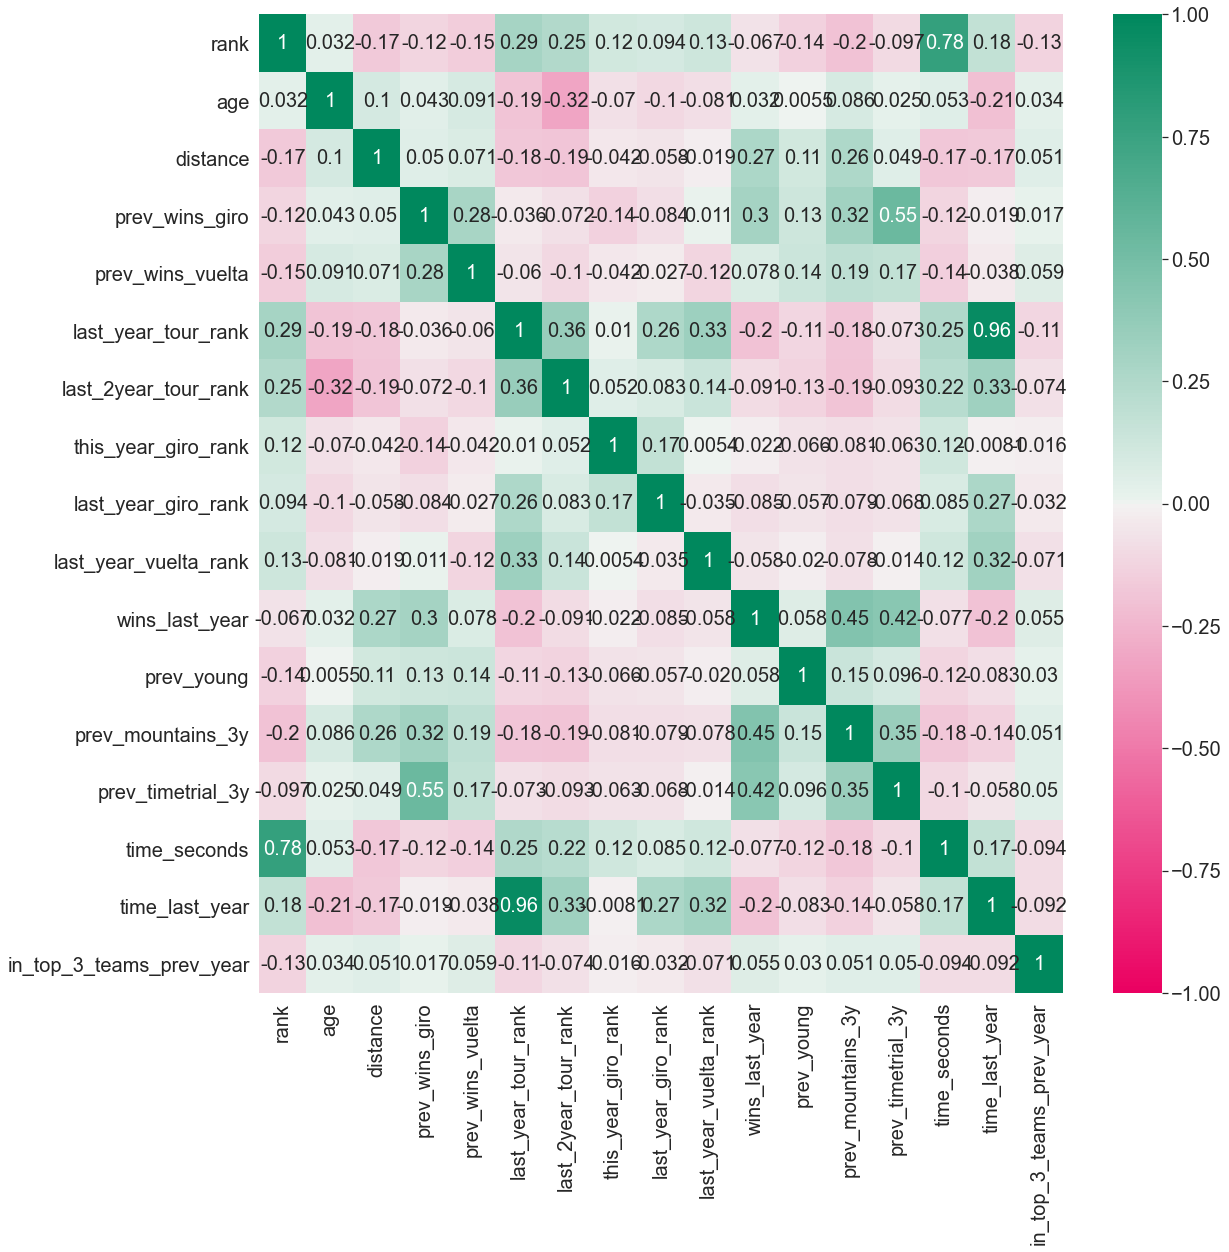

In [157]:
##Heat map of correlations between variables
sym_col = sns.diverging_palette(1, 150, s=100, as_cmap=True)

eda_cols = ['rank', 'age',
       'young', 'distance', 'prev_wins_giro',
       'prev_wins_vuelta', 'last_year_tour_rank', 'last_2year_tour_rank',
       'this_year_giro_rank', 'last_year_giro_rank', 'last_year_vuelta_rank',
       'wins_last_year', 'prev_young', 'prev_mountains_3y',
       'prev_timetrial_3y',  'time_seconds',
       'time_last_year', 'in_top_3_teams_prev_year']

plt.figure(figsize=(18,18))
sns.heatmap(tdf_ranks[eda_cols].corr(),annot=True, vmin=-1,vmax=1, center = 0, cmap=sym_col)
plt.show()

In [158]:
sns.set(rc={"figure.figsize":(10, 10),
           'font.size': 20.0,
             'axes.labelsize': 20.0,
             'axes.titlesize': 20.0,
             'xtick.labelsize': 20.0,
             'ytick.labelsize': 20.0,
             'legend.fontsize': 20.0,
           'legend.title_fontsize': 20.0})
sns.plotting_context(font_scale=5)

{'font.size': 20.0,
 'axes.labelsize': 20.0,
 'axes.titlesize': 20.0,
 'xtick.labelsize': 20.0,
 'ytick.labelsize': 20.0,
 'legend.fontsize': 20.0,
 'axes.linewidth': 1.25,
 'grid.linewidth': 1.0,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 1.25,
 'ytick.major.width': 1.25,
 'xtick.minor.width': 1.0,
 'ytick.minor.width': 1.0,
 'xtick.major.size': 6.0,
 'ytick.major.size': 6.0,
 'xtick.minor.size': 4.0,
 'ytick.minor.size': 4.0,
 'legend.title_fontsize': 20.0}

Text(0.5, 0, 'Number of times won Best Young Rider')

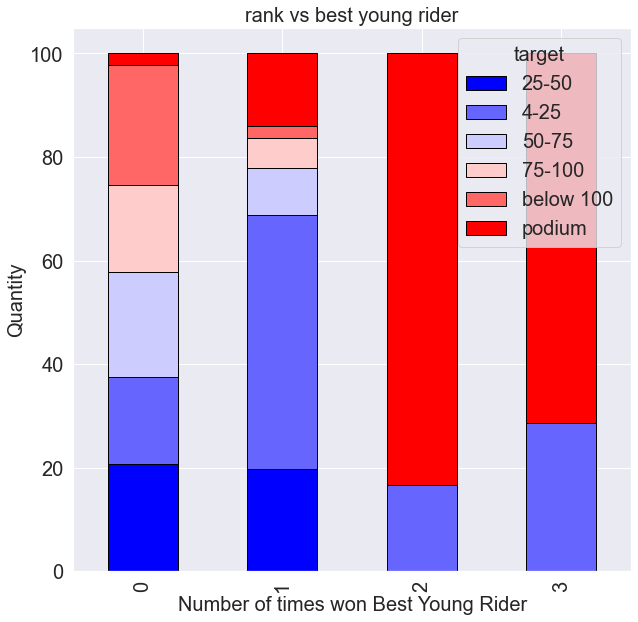

In [159]:
## stacked barchart for Distribution of target classes over number of times best young rider won

plotdata = pd.crosstab(tdf_ranks['prev_young'],tdf_ranks['target'])
stacked_plotdata = plotdata.apply(lambda x: x*100/sum(x), axis=1)
stacked_plotdata.plot(kind='bar', stacked=True, cmap="bwr", edgecolor = "black")
plt.title("rank vs best young rider")
plt.ylabel('Quantity')
plt.xlabel('Number of times won Best Young Rider')

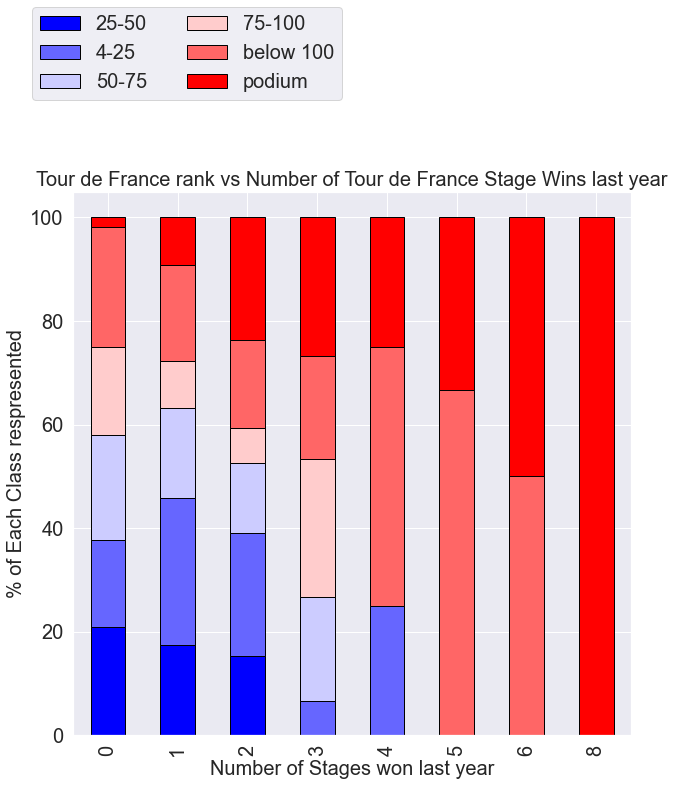

In [160]:
## stacked barchart for Distribution of target classes over number of stages won last year

plotdata = pd.crosstab(tdf_ranks['wins_last_year'],tdf_ranks['target'])
stacked_plotdata = plotdata.apply(lambda x: x*100/sum(x), axis=1)
stacked_plotdata.plot(kind='bar', stacked=True, cmap="bwr", edgecolor = "black")
plt.title("Tour de France rank vs Number of Tour de France Stage Wins last year")
plt.ylabel('% of Each Class respresented')
plt.xlabel('Number of Stages won last year')
plt.legend(loc="lower right", bbox_to_anchor=(0.5, 1.15), ncol=2)
#plt.savefig('rankvwins.png')

Text(0.5, 0, 'Rank')

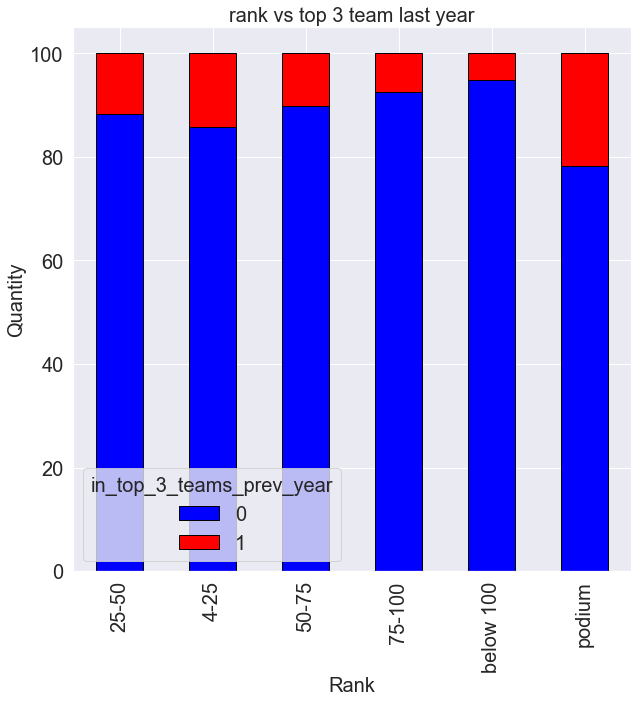

In [161]:
## stacked barchart for Distribution of whether a rider was in the top 3 teams of last year over target classes

plotdata = pd.crosstab(tdf_ranks['target'],tdf_ranks['in_top_3_teams_prev_year'])
stacked_plotdata = plotdata.apply(lambda x: x*100/sum(x), axis=1).sort_values(by='target')
stacked_plotdata.plot(kind='bar', stacked=True, cmap="bwr", edgecolor = "black")
plt.title("rank vs top 3 team last year")
plt.ylabel('Quantity')
plt.xlabel('Rank')

<AxesSubplot:xlabel='prev_mountains_3y', ylabel='time_seconds'>

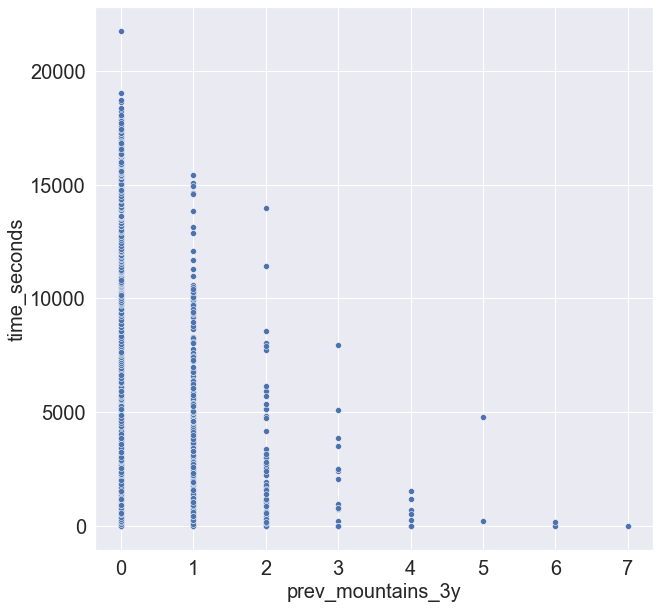

In [162]:
## Scatter plot of average win distance per target class

sns.scatterplot(data=tdf_ranks, x="prev_mountains_3y", y="time_seconds")

<AxesSubplot:xlabel='prev_timetrial_3y', ylabel='time_seconds'>

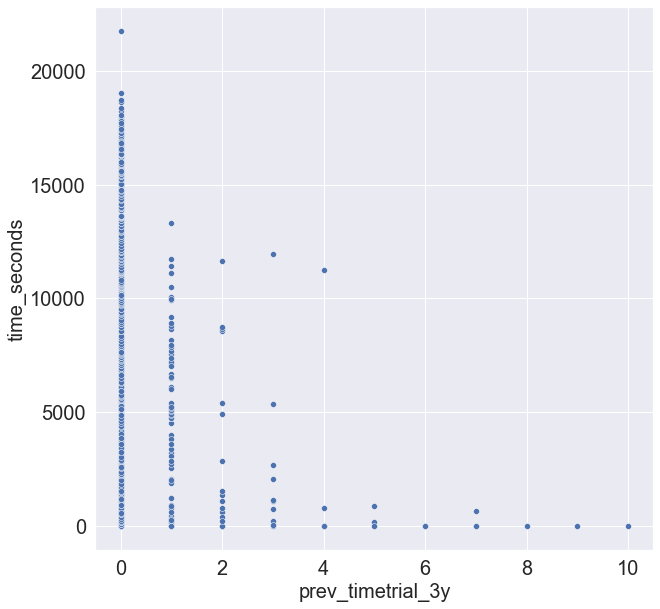

In [163]:
## Scatter plot of average win distance per target class

sns.scatterplot(data=tdf_ranks, x="prev_timetrial_3y", y="time_seconds")

[Text(0.5, 0, 'Tour de France Rank'),
 Text(0, 0.5, 'Tour de France Rank last year')]

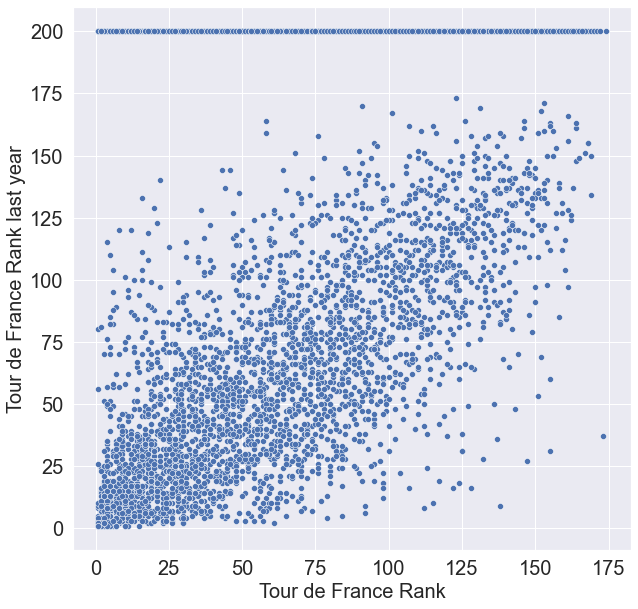

In [164]:
## Scatter plot of average win distance per target class
ax = sns.scatterplot(data=tdf_ranks, x="rank", y="last_year_tour_rank")
ax.set(xlabel='Tour de France Rank', ylabel='Tour de France Rank last year')

<AxesSubplot:xlabel='target', ylabel='distance'>

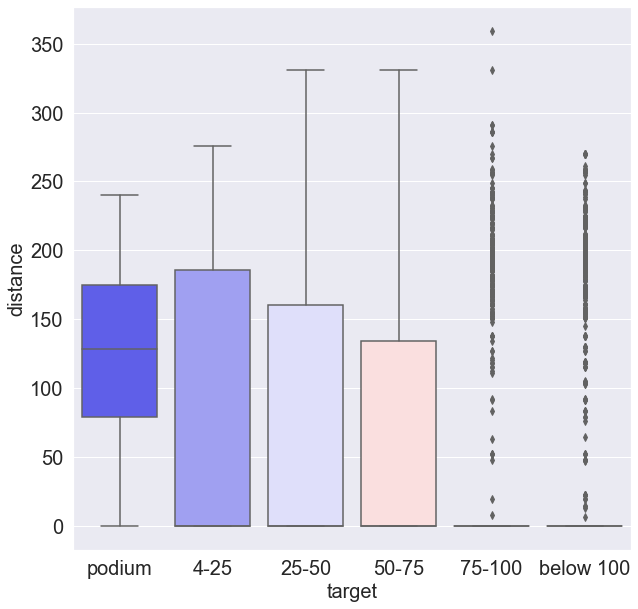

In [165]:
## Box plot of average win distance per target class

sns.boxplot(data=tdf_ranks,x="target", y="distance",palette='bwr')

Text(0.5, 0, 'Age')

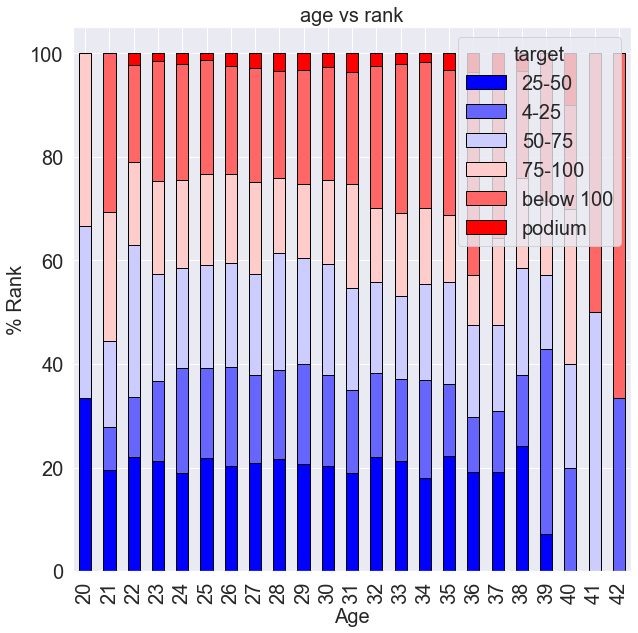

In [166]:
## stacked barchart for Distribution of whether a rider was in the top 3 teams of last year over target classes

plotdata = pd.crosstab(tdf_ranks['age'],tdf_ranks['target'])
stacked_plotdata = plotdata.apply(lambda x: x*100/sum(x), axis=1)
stacked_plotdata.plot(kind='bar', stacked=True, cmap="bwr", edgecolor = "black")
plt.title("age vs rank")
plt.ylabel('% Rank')
plt.xlabel('Age')

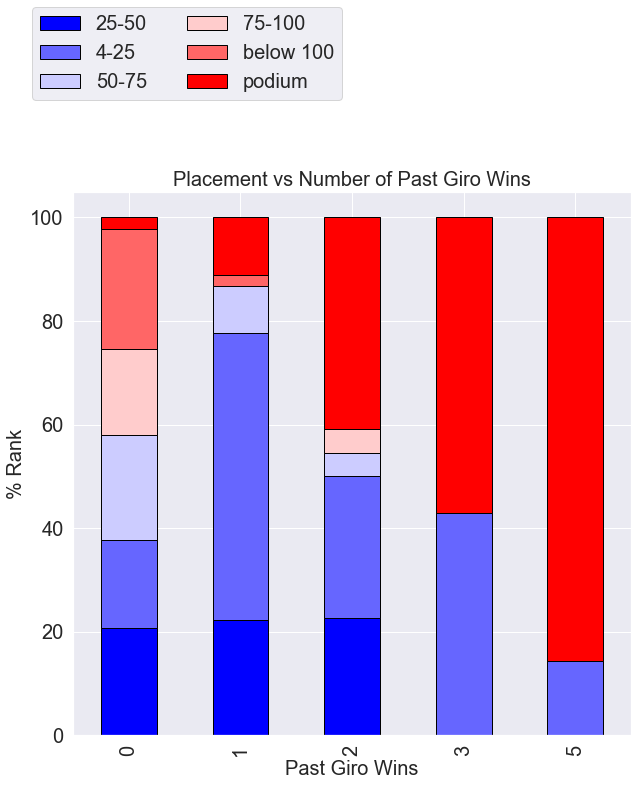

In [167]:
## stacked barchart for Distribution of whether a rider was in the top 3 teams of last year over target classes

plotdata = pd.crosstab(tdf_ranks['prev_wins_giro'],tdf_ranks['target'])
stacked_plotdata = plotdata.apply(lambda x: x*100/sum(x), axis=1)
stacked_plotdata.plot(kind='bar', stacked=True, cmap="bwr", edgecolor = "black")
plt.title("Placement vs Number of Past Giro Wins")
plt.ylabel('% Rank')
plt.xlabel('Past Giro Wins')
plt.legend(loc="lower right", bbox_to_anchor=(0.5, 1.15), ncol=2)

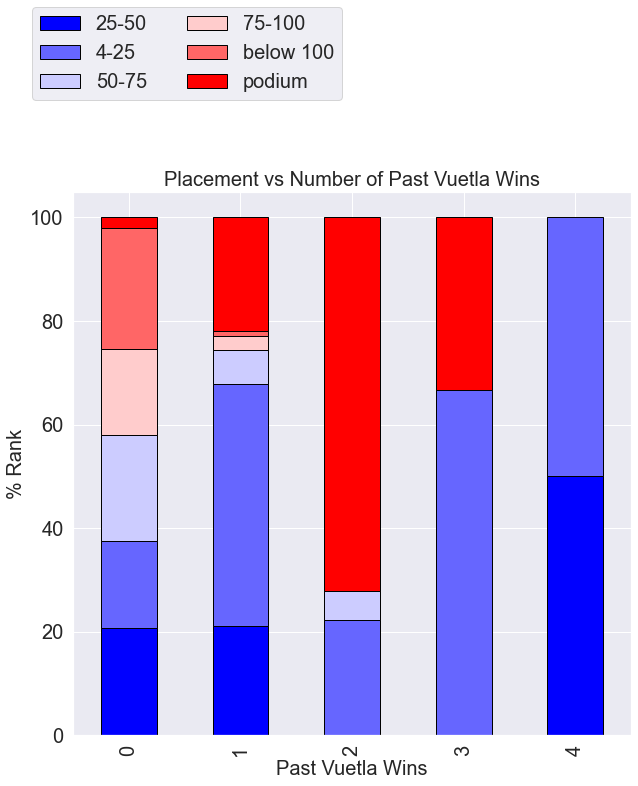

In [168]:
## stacked barchart for Distribution of whether a rider was in the top 3 teams of last year over target classes

plotdata = pd.crosstab(tdf_ranks['prev_wins_vuelta'],tdf_ranks['target'])
stacked_plotdata = plotdata.apply(lambda x: x*100/sum(x), axis=1)
stacked_plotdata.plot(kind='bar', stacked=True, cmap="bwr", edgecolor = "black")
plt.title("Placement vs Number of Past Vuetla Wins")
plt.ylabel('% Rank')
plt.xlabel('Past Vuetla Wins')
plt.legend(loc="lower right", bbox_to_anchor=(0.5, 1.15), ncol=2)

# Cutting Dataset

In [169]:
## Cutting the top year to ensure no 'N/A' for previous team
min_year = tdf_ranks['year'].min()
tdf_ranks = tdf_ranks[tdf_ranks['year']>min_year]

In [170]:
## Only including past Tour competitors 
tdf_ranks = tdf_ranks[tdf_ranks['time_last_year']<40000]

# Baseline for prediction: Last Year Result

In [171]:
## Creating a new column that is 1 if this year and last year's categories are identical, 0 otherwise
ident = []
for n in range(len(tdf_ranks)):
    if tdf_ranks.iloc[n,14] == tdf_ranks.iloc[n,29]:
        ident.append(1)
    else:
        ident.append(0)
ident2 = []
for n in range(len(tdf_ranks)):
    if tdf_ranks.iloc[n,15] == tdf_ranks.iloc[n,30]:
        ident2.append(1)
    else:
        ident2.append(0)

tdf_ranks['true_naive'] = ident
tdf_ranks['true_naive2'] = ident2

## Overall accuracy
accuracy_target = sum(ident)/len(ident)
accuracy_target2 = sum(ident2)/len(ident2)

## Printing results
print('Naïve accuracy for target:',accuracy_target,'Naïve accuracy for target 2:',accuracy_target2)

Naïve accuracy for target: 0.6072199938290651 Naïve accuracy for target 2: 0.4116013576056773


In [172]:
## Calculating the mean accuracy overall, for each year and the standard deviation
means = []
prevars = []
for y in range (1961,2018):
    new = tdf_ranks[tdf_ranks['year']==y]
    lst = list(new['true_naive'])
    mean = sum(lst)/len(lst)
    prevar = ((mean*100)-(accuracy_target*100))**2
    prevars.append(prevar) 
    means.append(mean)
overall_mean = sum(means)/len(means)
standard_dev = sqrt(sum(prevars)/len(prevars))
print('Overall mean of years: '+str(overall_mean)+ ', Standard Deviation: '+str(standard_dev))

Overall mean of years: 0.5901794497090364, Standard Deviation: 8.192116993464154


In [173]:
from sklearn.metrics import classification_report

In [174]:
print(classification_report(tdf_ranks.target_lastyr.values,tdf_ranks.target.values))

              precision    recall  f1-score   support

       25-50       0.35      0.33      0.34       738
        4-25       0.50      0.49      0.50       685
       50-75       0.29      0.30      0.29       623
      75-100       0.25      0.27      0.26       460
   below 100       0.63      0.62      0.62       623
      podium       0.52      0.50      0.51       112

    accuracy                           0.41      3241
   macro avg       0.42      0.42      0.42      3241
weighted avg       0.42      0.41      0.41      3241



In [175]:
## Calculating the mean accuracy overall, for each year and the standard deviation
means = []
prevars = []
for y in range (1961,2018):
    new = tdf_ranks[tdf_ranks['year']==y]
    lst = list(new['true_naive2'])
    mean = sum(lst)/len(lst)
    prevar = ((mean*100)-(accuracy_target2*100))**2
    prevars.append(prevar) 
    means.append(mean)
overall_mean = sum(means)/len(means)
standard_dev = sqrt(sum(prevars)/len(prevars))
print('Overall mean of years: '+str(overall_mean)+ ', Standard Deviation: '+str(standard_dev))

Overall mean of years: 0.40831541921095127, Standard Deviation: 9.896315026043546


<AxesSubplot:>

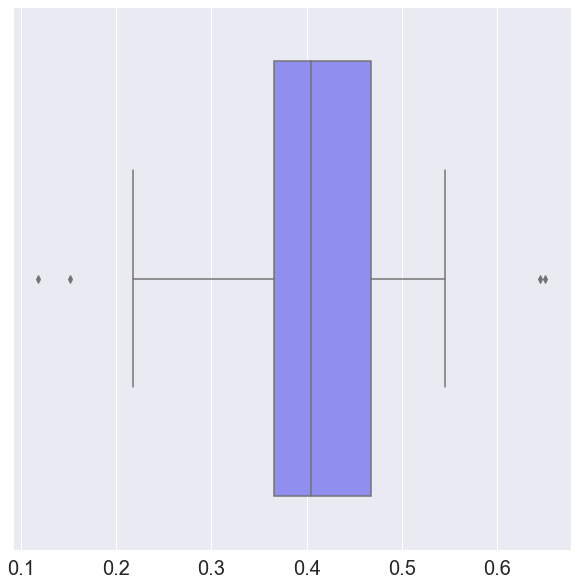

In [176]:
## Boxplot to show the quartiles of accuracy

sns.boxplot(x=means,palette='cool')

In [177]:
print(classification_report(tdf_ranks.target_2lastyr.values,tdf_ranks.target2.values))

              precision    recall  f1-score   support

       26-50       0.33      0.31      0.32       708
        4-25       0.52      0.51      0.51       715
       51-75       0.29      0.30      0.29       623
    below 75       0.69      0.71      0.70      1083
      podium       0.52      0.50      0.51       112

    accuracy                           0.49      3241
   macro avg       0.47      0.47      0.47      3241
weighted avg       0.49      0.49      0.49      3241



<AxesSubplot:>

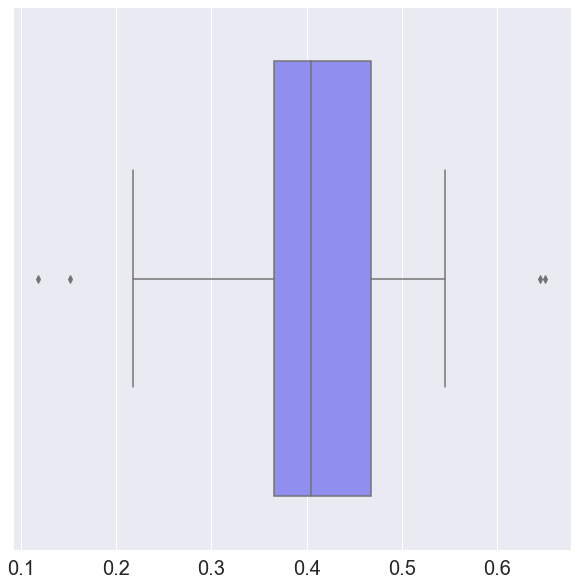

In [178]:
## Boxplot to show the quartiles of accuracy

sns.boxplot(x=means,palette='cool')

# Prediction Dataframe

In [179]:
# 
feature_cols = ['age'
                ,'distance'
                ,'prev_wins_giro'
                ,'prev_wins_vuelta'
                ,'in_top_3_teams_prev_year'
                ,'wins_last_year'
                ,'prev_young'
                ,'time_last_year'
                ,'last_year_tour_rank'
                ,'prev_mountains_3y'
                ,'prev_timetrial_3y'
                ,'last_year_vuelta_rank'
                ,'last_year_giro_rank'
                ,'last_2year_tour_rank'
                ,'this_year_giro_rank'
               ]

X = tdf_ranks[feature_cols]
y = tdf_ranks['target']

import random
random.seed(124)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y,random_state = 244)

In [180]:
X = tdf_ranks[feature_cols]
y = tdf_ranks['target']

In [181]:
# taking chunks of data each time 
tree = DecisionTreeClassifier(random_state=144)

scores = cross_val_score(tree, X_train, y_train, cv = 12)

print(scores)

[0.35185185 0.31944444 0.26388889 0.32407407 0.33796296 0.38425926
 0.33796296 0.34722222 0.37037037 0.31018519 0.34722222 0.37037037]


In [182]:
# average score 
sum(scores) / len(scores)

0.3387345679012346

In [183]:
rf = RandomForestClassifier(n_estimators=150, max_depth = 8, min_samples_leaf=10, random_state=24)
et = ExtraTreesClassifier(n_estimators=150,max_depth = 5)

In [184]:
## gives us a more relable score - splitting out the data and averaging it out 

rf_score = cross_val_score(rf, X_train, y_train, cv=5).mean()
et_score = cross_val_score(et, X_train, y_train, cv=5).mean()

In [185]:
print(f'Random scored {rf_score}')
print(f'Extra Random scored {et_score}')

Random scored 0.4274830569628258
Extra Random scored 0.42130619471659936


In [186]:
### Grid search to find best parameters
# {'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 150}
rf_params = {
    'n_estimators': [100, 150, 200, 500],
    'max_depth': [6, 8, 9,10],
    'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11]
}


#gs = GridSearchCV(rf, param_grid=rf_params, cv=5)

#gs.fit(X_train, y_train)

#print(gs.best_score_)

#gs.best_params_

In [187]:
#gs.score(X_train, y_train)

In [188]:
## Predict on Train

rf.fit(X_train, y_train)

#
train_results = X_train.copy()
train_results['y_pred'] = rf.predict(X_train)
train_results['y_real'] = y_train
train_results['y_prob'] = rf.predict_proba(X_train)[:,1]

#train_results

In [189]:
accuracy_train = accuracy_score(train_results['y_real'], train_results['y_pred'])
print('Accuracy: %.3f' % accuracy_train)
precision = precision_score(train_results['y_real'], train_results['y_pred'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(train_results['y_real'], train_results['y_pred'], average='weighted')
print('Recall: %.3f' % recall)
f1 = f1_score(train_results['y_real'], train_results['y_pred'], average='weighted')
print('F1: %.3f' % f1)

Accuracy: 0.515
Precision: 0.533
Recall: 0.515
F1: 0.483


In [190]:
false = train_results[(train_results['y_pred']==train_results['y_real'])==False]

In [191]:
true = train_results[(train_results['y_pred']==train_results['y_real'])==True]

In [192]:
len(false)

1256

In [193]:
len(true)

1336

In [194]:
from sklearn.metrics import classification_report

In [195]:
print(classification_report(train_results.y_pred.values,train_results.y_real.values))

              precision    recall  f1-score   support

       25-50       0.49      0.46      0.48       596
        4-25       0.70      0.55      0.62       685
       50-75       0.45      0.42      0.44       546
      75-100       0.09      0.64      0.16        59
   below 100       0.80      0.58      0.67       674
      podium       0.28      0.75      0.41        32

    accuracy                           0.52      2592
   macro avg       0.47      0.57      0.46      2592
weighted avg       0.61      0.52      0.55      2592



Text(0.5, 0, 'Random Forest Feature Importance')

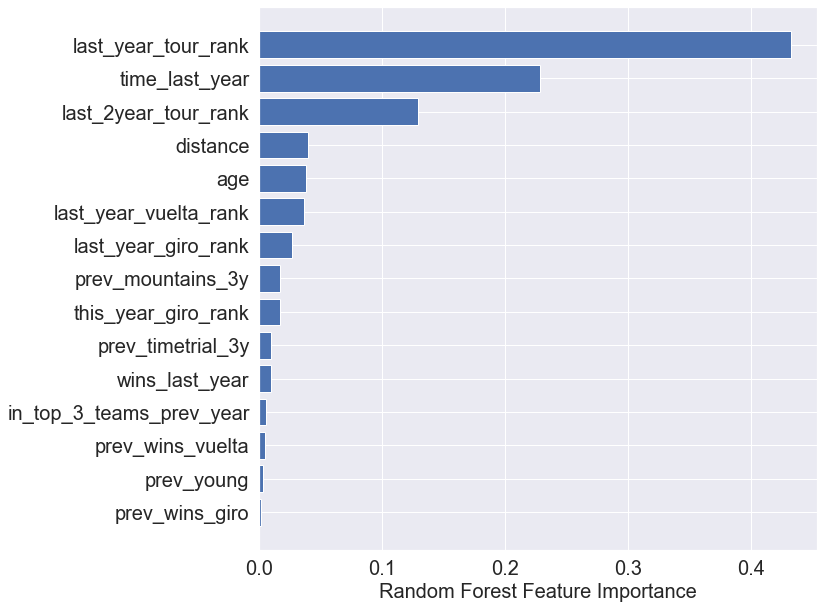

In [196]:
## Bar chart showing feature importances

sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

#plt.barh(X_train.columns, rf.feature_importances_)

## Test

In [197]:
## Predict on Test

test_results = X_test.copy()
test_results['y_pred'] = rf.predict(X_test)
test_results['y_real'] = y_test
test_results['y_prob'] = rf.predict_proba(X_test)[:,1]

In [198]:
print(classification_report(test_results.y_pred.values,test_results.y_real.values))

              precision    recall  f1-score   support

       25-50       0.46      0.42      0.44       154
        4-25       0.64      0.51      0.57       168
       50-75       0.39      0.35      0.37       143
      75-100       0.07      0.64      0.13        11
   below 100       0.81      0.59      0.69       167
      podium       0.18      0.67      0.29         6

    accuracy                           0.48       649
   macro avg       0.43      0.53      0.41       649
weighted avg       0.57      0.48      0.51       649



In [199]:
## Accuracy, Precision, Recall, and F1

accuracy_test = accuracy_score(test_results['y_real'], test_results['y_pred'])
print('Accuracy: %.3f' % accuracy_test)
precision = precision_score(test_results['y_real'], test_results['y_pred'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(test_results['y_real'], test_results['y_pred'], average='weighted')
print('Recall: %.3f' % recall)
f1 = f1_score(test_results['y_real'], test_results['y_pred'], average='weighted')
print('F1: %.3f' % f1)

Accuracy: 0.479
Precision: 0.500
Recall: 0.479
F1: 0.444


In [200]:
true = test_results[(test_results['y_pred']==test_results['y_real'])==True]
len(true)

311

In [201]:
false = test_results[(test_results['y_pred']==test_results['y_real'])==False]
len(false)

338

## Accuracy of Test + Train by Year

In [202]:
combined = pd.concat([test_results, train_results])

In [203]:
combined['accuracy'] = combined['y_pred'] == combined['y_real']

In [204]:
combined = combined.join(tdf_ranks[['year']])

In [205]:
means = []
prevars = []
for y in range (1981,2018):
    new = combined[combined['year']==y]
    lst = list(new['accuracy'])
    mean = sum(lst)/len(lst)
    prevar = ((mean*100)-(((accuracy_train+accuracy_test)/2)*100))**2
    prevars.append(prevar) 
    means.append(mean)
    
overall_mean = sum(means)/len(means)
from math import sqrt
standard_dev = sqrt(sum(prevars)/len(prevars))
print('Overall mean: '+str(overall_mean)+ ', Standard Deviation: '+str(standard_dev))

Overall mean: 0.4882670254982947, Standard Deviation: 9.239904190690016


<AxesSubplot:>

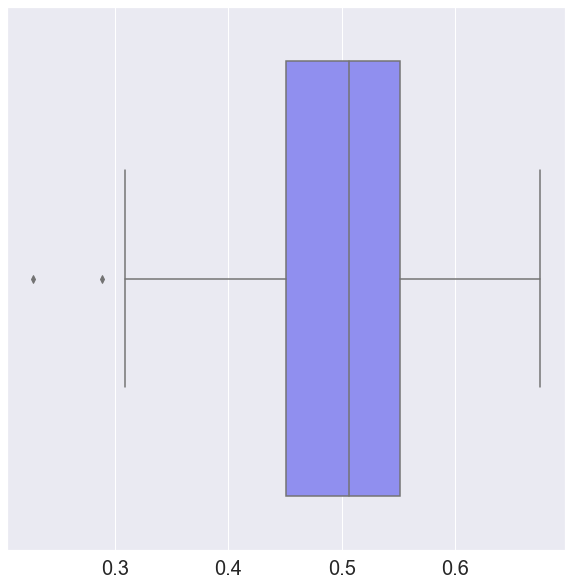

In [206]:
## IQR of mean accuracy per year for test + train 
sns.boxplot(x=means,palette='cool')

## Accuracy of Just Test

In [207]:
recombined = test_results.join(tdf_ranks[['year']])

In [208]:
recombined['accuracy'] = recombined['y_pred'] == recombined['y_real']

In [209]:
recombined['accuracy'] = recombined['accuracy'].astype(int)

In [210]:
means = []
prevars = []
for y in range (1981,2018):
    new = recombined[recombined['year']==y]
    lst = list(new['accuracy'])
    mean = sum(lst)/len(lst)
    prevar = ((mean*100)-(accuracy_test*100))**2
    prevars.append(prevar) 
    means.append(mean)
overall_mean = sum(means)/len(means)
from math import sqrt
standard_dev = sqrt(sum(prevars)/len(prevars))
print('Overall mean: '+str(overall_mean)+ ', Standard Deviation: '+str(standard_dev))

Overall mean: 0.4556669911546074, Standard Deviation: 18.345624735384277


<AxesSubplot:>

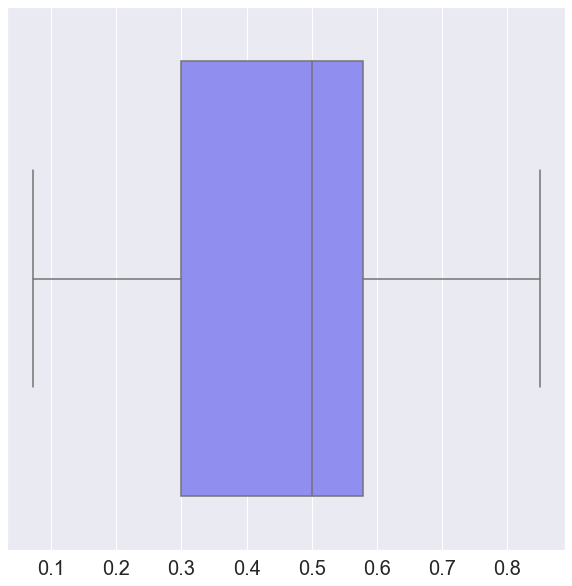

In [211]:
## IQR of mean accuracy per year for test 
sns.boxplot(x=means,palette='cool')

# Modified Targets

## Smaller Classes

In [212]:
X = tdf_ranks[feature_cols]
y = tdf_ranks['target2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [213]:
# taking chunks of data each time 
tree = DecisionTreeClassifier(random_state=124)

scores = cross_val_score(tree, X_train, y_train, cv = 12)

In [214]:
print(scores)

[0.41269841 0.38095238 0.46031746 0.42857143 0.3968254  0.41269841
 0.45502646 0.3968254  0.37566138 0.4021164  0.40740741 0.47089947]


In [215]:
## gives us a more relable score - splitting out the data and averaging it out 

rf_score = cross_val_score(rf, X_train, y_train, cv=5).mean()
et_score = cross_val_score(et, X_train, y_train, cv=5).mean()

In [216]:
##

print(f'Random scored {rf_score}')
print(f'Extra Random scored {et_score}')

Random scored 0.5251383337709445
Extra Random scored 0.48060215304723286


In [217]:
## Predict on Train

rf.fit(X_train, y_train)

#
train_results = X_train.copy()
train_results['y_pred'] = rf.predict(X_train)
train_results['y_real'] = y_train
train_results['y_prob'] = rf.predict_proba(X_train)[:,1]

#train_results

## Check Accuracy, Precision, Recall & F1

In [218]:
accuracy = accuracy_score(train_results['y_real'], train_results['y_pred'])
print('Accuracy: %.3f' % accuracy)
precision = precision_score(train_results['y_real'], train_results['y_pred'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(train_results['y_real'], train_results['y_pred'], average='weighted')
print('Recall: %.3f' % recall)
f1 = f1_score(train_results['y_real'], train_results['y_pred'], average='weighted')
print('F1: %.3f' % f1)

Accuracy: 0.602
Precision: 0.598
Recall: 0.602
F1: 0.580


In [219]:
rf.feature_importances_

array([0.03568597, 0.04232782, 0.00181793, 0.00573379, 0.00575956,
       0.00885431, 0.00732186, 0.24348315, 0.4035269 , 0.01634076,
       0.00891379, 0.03213241, 0.01941149, 0.15234134, 0.01634892])

<BarContainer object of 15 artists>

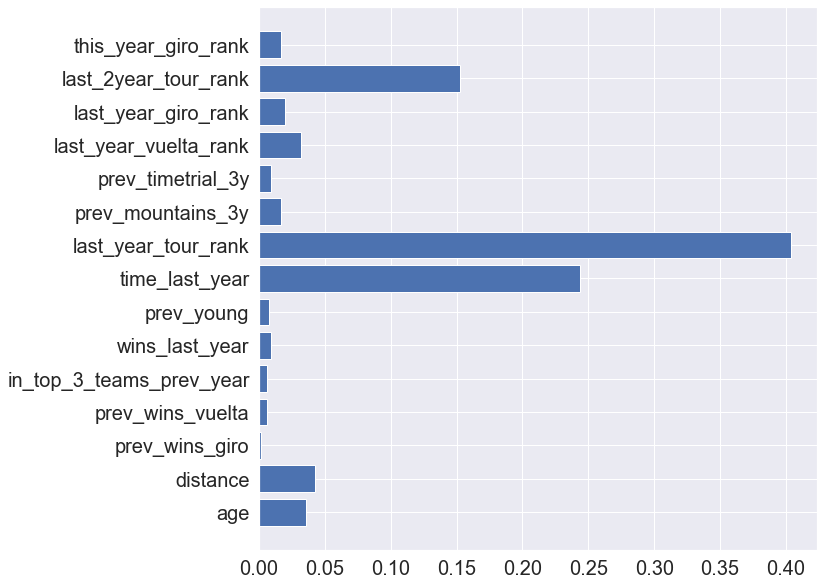

In [220]:
plt.barh(X_train.columns, rf.feature_importances_)

In [221]:
print(classification_report(train_results.y_pred.values,train_results.y_real.values))

              precision    recall  f1-score   support

       26-50       0.41      0.50      0.45       383
        4-25       0.73      0.55      0.63       648
       51-75       0.29      0.58      0.39       228
    below 75       0.84      0.67      0.75       978
      podium       0.35      0.84      0.49        31

    accuracy                           0.60      2268
   macro avg       0.52      0.63      0.54      2268
weighted avg       0.67      0.60      0.62      2268



In [222]:
## Predict on Test

#rf.fit(X_test, y_test)

#
test_results = X_test.copy()
test_results['y_pred'] = rf.predict(X_test)
test_results['y_real'] = y_test
test_results['y_prob'] = rf.predict_proba(X_test)[:,1]

#test_results
## Check Accuracy, Precision, Recall & F1

In [223]:
accuracy = accuracy_score(test_results['y_real'], test_results['y_pred'])
print('Accuracy: %.3f' % accuracy)
precision = precision_score(test_results['y_real'], test_results['y_pred'], average='weighted')
print('Precision: %.3f' % precision)
recall = recall_score(test_results['y_real'], test_results['y_pred'], average='weighted')
print('Recall: %.3f' % recall)
f1 = f1_score(test_results['y_real'], test_results['y_pred'], average='weighted')
print('F1: %.3f' % f1)

Accuracy: 0.523
Precision: 0.484
Recall: 0.523
F1: 0.480


In [224]:
print(classification_report(test_results.y_pred.values,test_results.y_real.values))

              precision    recall  f1-score   support

       26-50       0.25      0.36      0.29       143
        4-25       0.68      0.48      0.57       296
       51-75       0.14      0.34      0.20        83
    below 75       0.84      0.64      0.73       444
      podium       0.12      0.57      0.21         7

    accuracy                           0.52       973
   macro avg       0.41      0.48      0.40       973
weighted avg       0.64      0.52      0.57       973

